In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

##Clustering##
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import (dendrogram , cut_tree)
from ISLP.cluster import compute_linkage

# Clustering

Lets apply hirerical clustering and pca to the data and see if we can find the group of migrator starts by this approach. 

In [2]:
import os
PathToRepo = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data = pd.read_csv(PathToRepo + '\\Data\\Faellesdata_cleaned.csv')
scaler = StandardScaler(with_std=True, with_mean=True)
isMigrator = data['IsMigratorInt']
data = data.drop(['IsMigratorInt'], axis=1)
data_scaled = scaler.fit_transform(data)

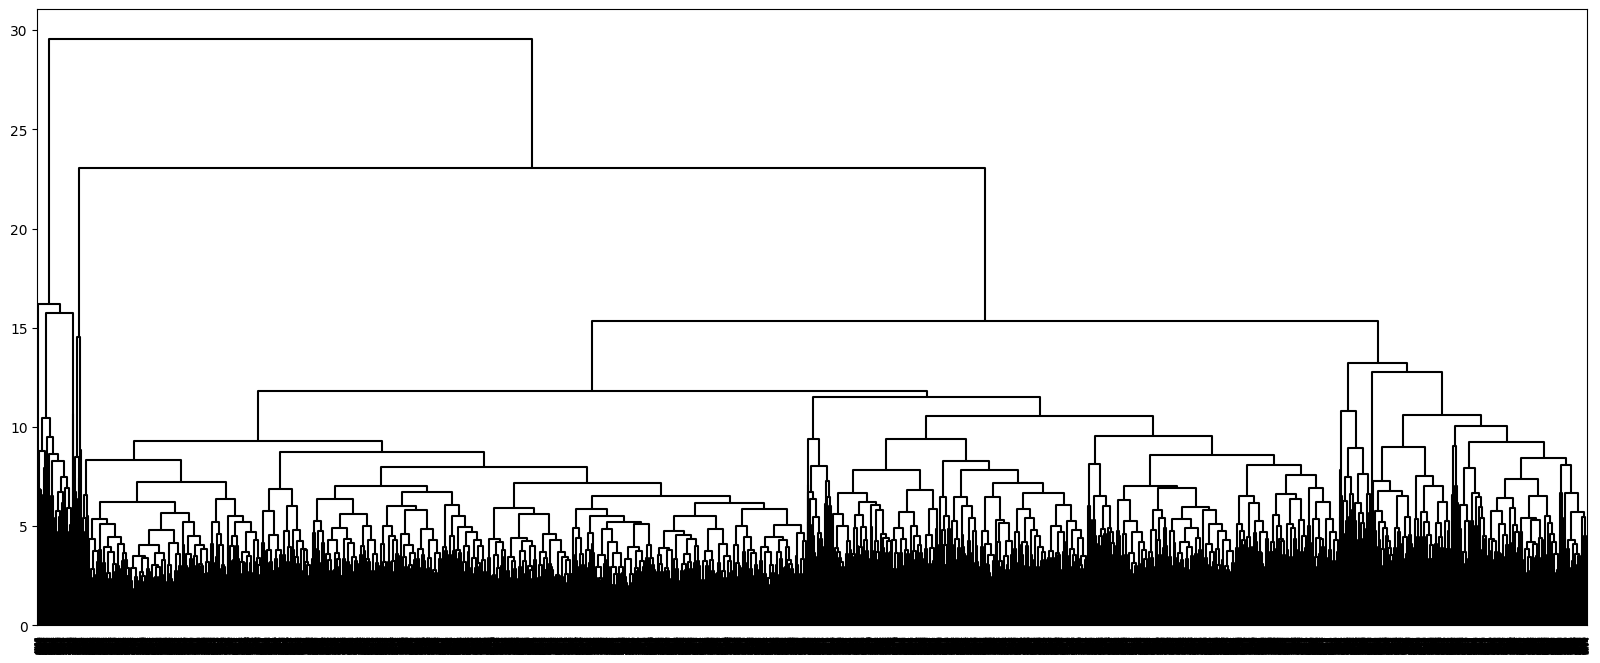

In [3]:
HClust = AgglomerativeClustering 
hc_comp = HClust(distance_threshold=0, n_clusters=None, linkage='complete')
hc_comp.fit(data_scaled)

cargs = {'color_threshold':-np.inf, 'above_threshold_color':'black'} #to avoid precoloring the dendrogram
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
dendrogram(linkage_comp, ax=ax, **cargs);

Looking at this we cut at height 12 

In [4]:
height = 13
cluster_label = cut_tree(linkage_comp, height = height ).flatten()
np.unique(cluster_label)

array([0, 1, 2, 3, 4, 5, 6, 7])

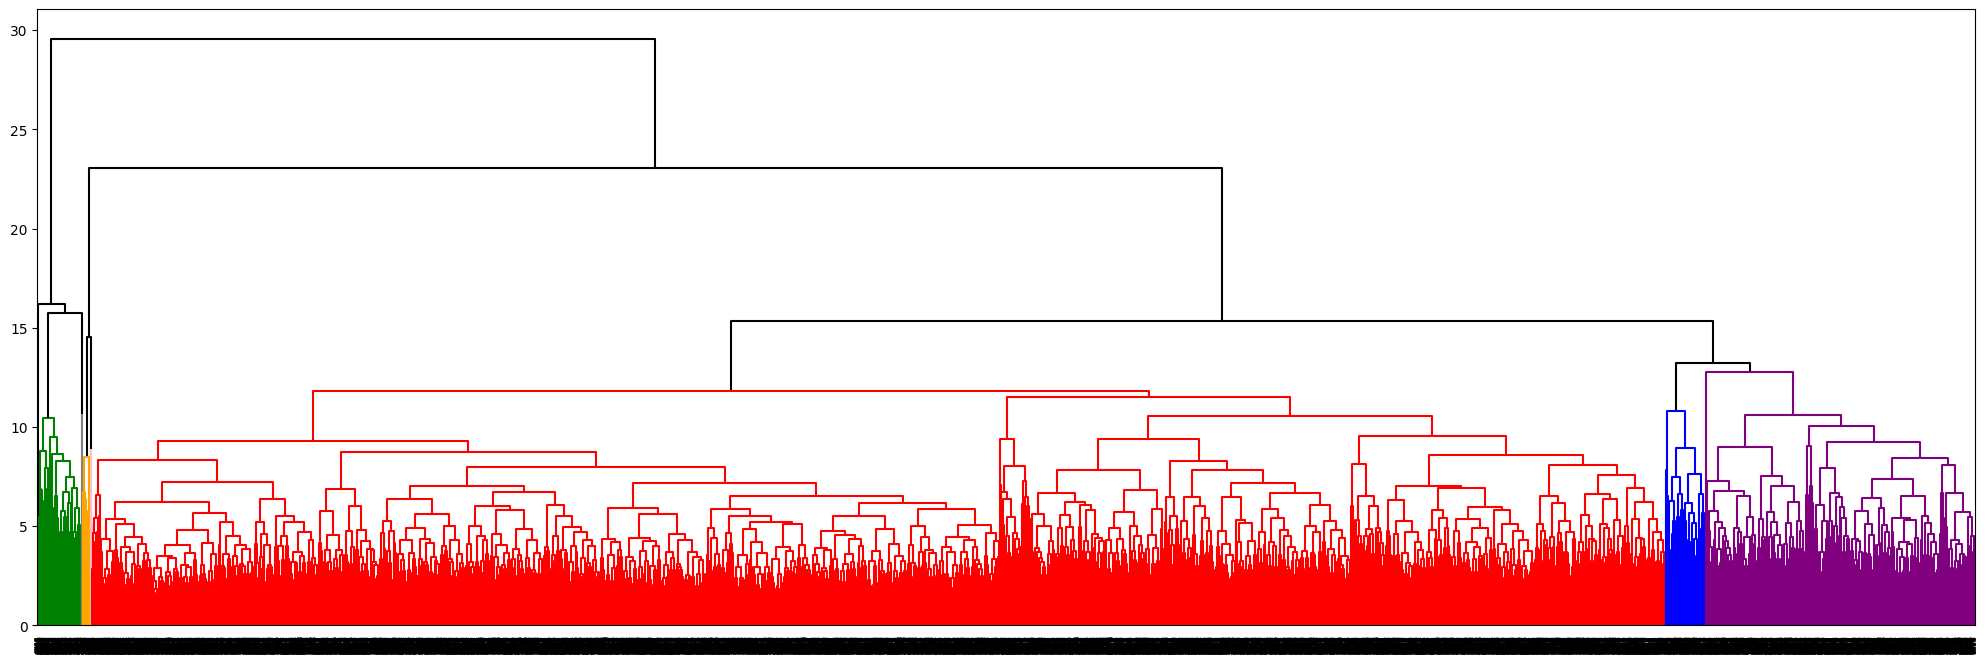

In [5]:
cluster_colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'grey']
label_color_map = {i: cluster_colors[i] for i in range(len(cluster_colors))}

# Create a color function for the branches taken from homework 11 
def branch_color_func(linkage_comp, cluster_labels, num_leaves):
    """Generate a color function for the branches of the dendrogram based on cluster labels.
    Returns: A function to use as `link_color_func` in `dendrogram`"""
    # Create a dictionary to map node IDs to colors
    node_to_color = {}

    # Initialize leaf nodes with their cluster colors
    for i in range(num_leaves):
        node_to_color[i] = label_color_map[cluster_labels[i]]

    # Propagate colors upward through the hierarchy
    for i, (left, right, _, _) in enumerate(linkage_comp):
        node_id = i + num_leaves  # Non-leaf node ID
        left_color = node_to_color[int(left)]
        right_color = node_to_color[int(right)]

        # If both children have the same color, propagate it; otherwise, default to black
        if left_color == right_color:
            node_to_color[node_id] = left_color
        else:
            node_to_color[node_id] = 'black'

    # Define a function to return the color for a given node ID
    def color_func(node_id):
        return node_to_color[node_id]
    return color_func

# Generate the color function
link_color_func = branch_color_func(linkage_comp, cluster_label, len(cluster_label))

fig, ax = plt.subplots(1, 1, figsize=(25, 8))
dendrogram(linkage_comp, ax=ax, link_color_func = link_color_func)
plt.xticks(rotation=90)
plt.savefig(PathToRepo + '\\Plots\\Dendrogram.png')
plt.show()

We now use PCA on it too. 

In [6]:
pcaMigrator = PCA()
pcaMigrator.fit(data_scaled)

PCA()

The scores are the projections of each data point onto the principal components. So first column is PC1, next PC2 and so on. 

In [7]:
pcaMigrator.components_ # in this one it is stored according to the columns of the original data so the first row is for z next vz and so on and the rows are for the prinicipal components.
scores = pcaMigrator.transform(data_scaled)

In [8]:
#print the explained variance formatted nicely with only 3 decimals
print('Explained variance ratio:')
print('\n'.join([f'PC{i+1}: {var:.3f}' for i, var in enumerate(pcaMigrator.explained_variance_ratio_)]))

Explained variance ratio:
PC1: 0.461
PC2: 0.100
PC3: 0.069
PC4: 0.068
PC5: 0.066
PC6: 0.064
PC7: 0.057
PC8: 0.049
PC9: 0.041
PC10: 0.016
PC11: 0.009
PC12: 0.002
PC13: 0.000
PC14: 0.000
PC15: 0.000


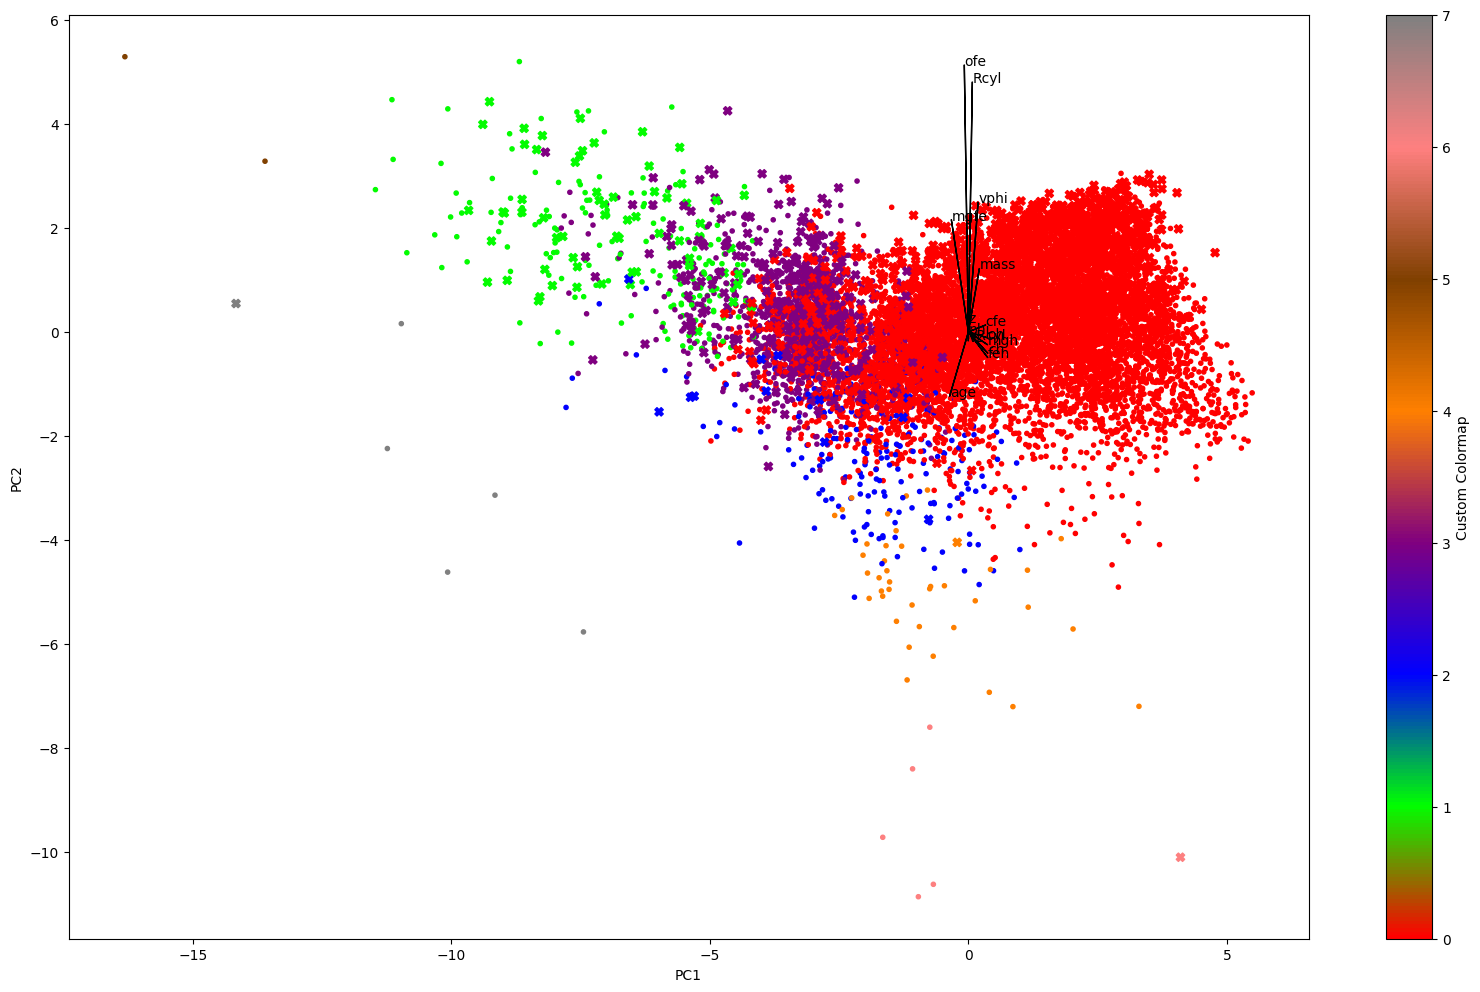

In [9]:
scale_arrow = s_ = 8
i, j = 0, 1 # which components

#color of clusters 
#make it so it maches  ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'grey']
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (0.5, 0, 0.5), (1, 0.5, 0), (0.5, 0.25, 0), (1, 0.5, 0.5), (0.5, 0.5, 0.5)] 
node_lin_space = np.linspace(0, 1, len(colors))
nodes = node_lin_space.tolist()  # Position of colors in the colormap (0=low, 1=high)

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

fig, ax = plt.subplots(1, 1, figsize=(20, 12)) 

mask1 = isMigrator == 1
mask0 = isMigrator == 0


scatter0 = ax.scatter(scores[:,0][mask0], scores[:,1][mask0], marker = '.', c = cluster_label[mask0], cmap=custom_cmap)
scatter1 = ax.scatter(scores[:,0][mask1], scores[:,1][mask1], marker = 'X', c = cluster_label[mask1], cmap=custom_cmap) 


ax.set_xlabel('PC%d' % (i+1))  
ax.set_ylabel('PC%d' % (j+1))

#This part is for plotting the components ie murder, assult, urbanpop and rape. 
for k in range(pcaMigrator.components_.shape[1]):
    ax.arrow(0, 0, pcaMigrator.components_[i,k], s_ * pcaMigrator.components_[j,k]) 
    ax.text(pcaMigrator.components_[i,k], s_ * pcaMigrator.components_[j,k], 
            data.columns[k])


cbar0 = plt.colorbar(scatter0, ax=ax)
cbar0.set_label("Custom Colormap")
plt.savefig(PathToRepo + '\\Plots\\Biplot_with_clustering')

What groups have most migrator stars. 

In [10]:
#what cluster has most migrator stars
cluster_migrator_ratio = []


for k in (np.unique(cluster_label)):
    cluster_migrator = []
    cluster_index = np.where(cluster_label == k)[0]

    for i in cluster_index:
        cluster_migrator.append(isMigrator[i])

    cluster_ratio = np.sum(cluster_migrator)/len(cluster_migrator)    
    cluster_migrator_ratio.append(cluster_ratio)

print(cluster_migrator_ratio)

[0.18433690432212782, 0.28193832599118945, 0.057692307692307696, 0.14265129682997119, 0.024390243902439025, 0.0, 0.16666666666666666, 0.16666666666666666]


C:\Users\lorentsen\AppData\Local\Temp\ipykernel_112932\1604542870.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', n_clusters)


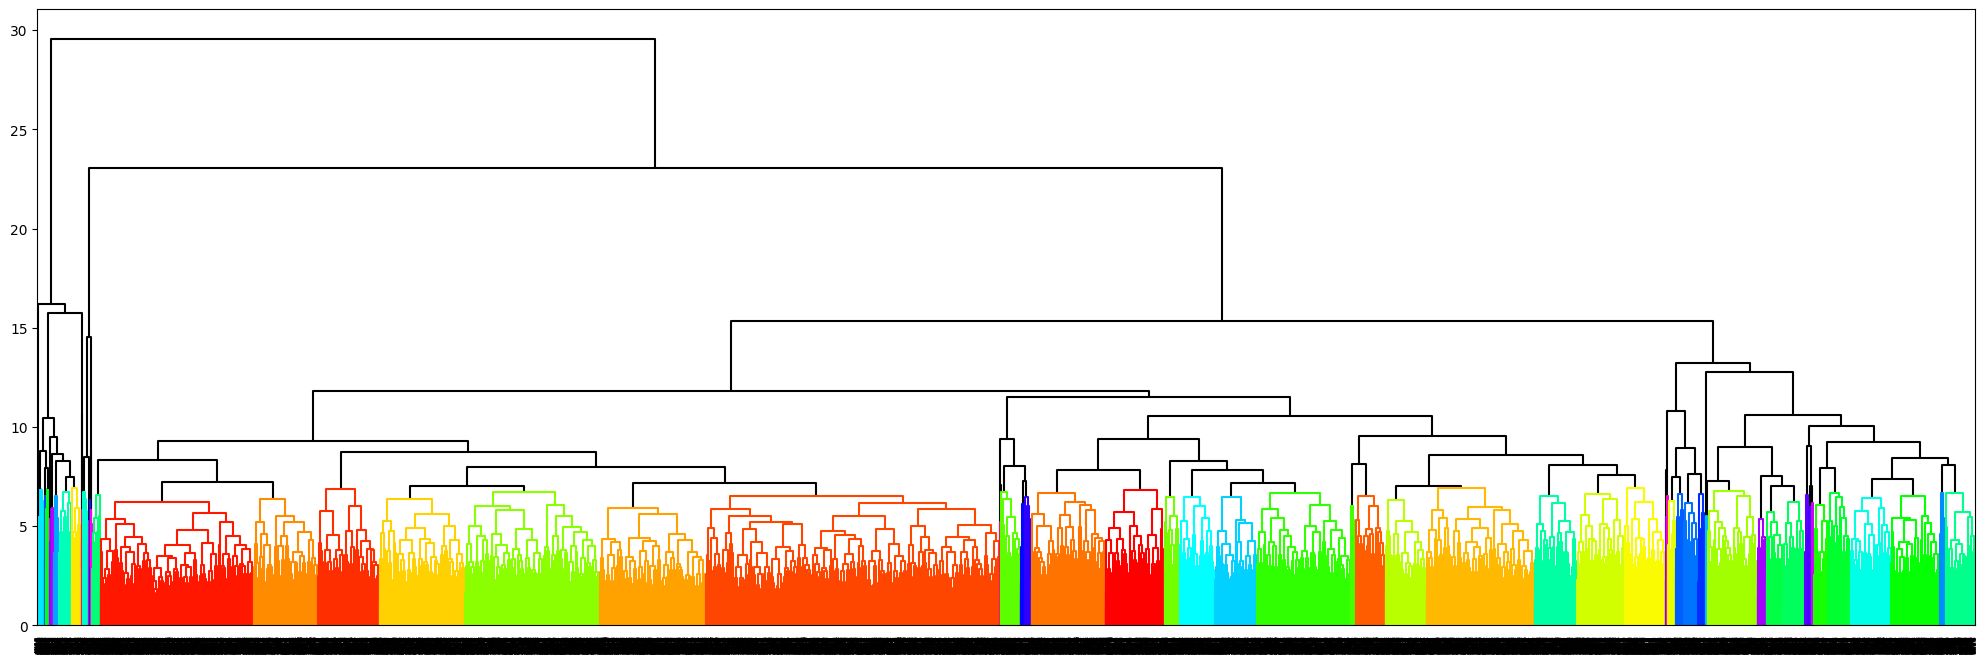

In [11]:
from matplotlib.colors import to_hex
height = 7
cluster_label = cut_tree(linkage_comp, height = height ).flatten()

n_clusters = len(np.unique(cluster_label))
# Generate a list of colors using a colormap
cmap = plt.cm.get_cmap('hsv', n_clusters)
cluster_colors = [to_hex(cmap(i)) for i in range(n_clusters)]


label_color_map = {i: cluster_colors[i] for i in range(len(cluster_colors))}

# Create a color function for the branches taken from homework 11 
def branch_color_func(linkage_comp, cluster_labels, num_leaves):
    """Generate a color function for the branches of the dendrogram based on cluster labels.
    Returns: A function to use as `link_color_func` in `dendrogram`"""
    # Create a dictionary to map node IDs to colors
    node_to_color = {}

    # Initialize leaf nodes with their cluster colors
    for i in range(num_leaves):
        node_to_color[i] = label_color_map[cluster_labels[i]]

    # Propagate colors upward through the hierarchy
    for i, (left, right, _, _) in enumerate(linkage_comp):
        node_id = i + num_leaves  # Non-leaf node ID
        left_color = node_to_color[int(left)]
        right_color = node_to_color[int(right)]

        # If both children have the same color, propagate it; otherwise, default to black
        if left_color == right_color:
            node_to_color[node_id] = left_color
        else:
            node_to_color[node_id] = '#000000'

    # Define a function to return the color for a given node ID
    def color_func(node_id):
        return node_to_color[node_id]
    return color_func

# Generate the color function
link_color_func = branch_color_func(linkage_comp, cluster_label, len(cluster_label))

fig, ax = plt.subplots(1, 1, figsize=(25, 8))
dendrogram(linkage_comp, ax=ax, link_color_func = link_color_func)
plt.xticks(rotation=90)
plt.show()


In [12]:
#what cluster has most migrator stars
cluster_migrator_ratio = []
len_list = []


for k in (np.unique(cluster_label)):
    cluster_migrator = []
    cluster_index = np.where(cluster_label == k)[0]

    for i in cluster_index:
        cluster_migrator.append(isMigrator[i])

    cluster_ratio = np.sum(cluster_migrator)/len(cluster_migrator)    
    cluster_migrator_ratio.append(cluster_ratio)
    len_list.append(len(cluster_index))

ratio_and_number_stars = list(zip(cluster_migrator_ratio, len_list))
print(ratio_and_number_stars)

[(0.11764705882352941, 306), (0.06944444444444445, 792), (0.42452830188679247, 318), (0.10810810810810811, 1517), (0.0915032679738562, 153), (0.1544502617801047, 382), (0.05757575757575758, 330), (0.5521023765996343, 547), (0.13129496402877697, 556), (0.2018140589569161, 441), (0.1320754716981132, 53), (0.12735849056603774, 212), (0.125, 40), (0.045081967213114756, 244), (0.11848341232227488, 211), (0.08139534883720931, 258), (0.13218390804597702, 696), (0.02531645569620253, 79), (0.20588235294117646, 102), (0.0, 26), (0.48459958932238195, 487), (0.125, 72), (0.11155378486055777, 251), (0.42105263157894735, 19), (0.3793103448275862, 116), (0.11627906976744186, 86), (0.12389380530973451, 113), (0.0, 45), (0.10067114093959731, 149), (0.10407239819004525, 221), (0.31746031746031744, 63), (0.03333333333333333, 30), (0.13333333333333333, 210), (0.0446927374301676, 179), (0.25, 36), (0.41203703703703703, 216), (0.14285714285714285, 7), (0.2962962962962963, 27), (0.25806451612903225, 31), (0.

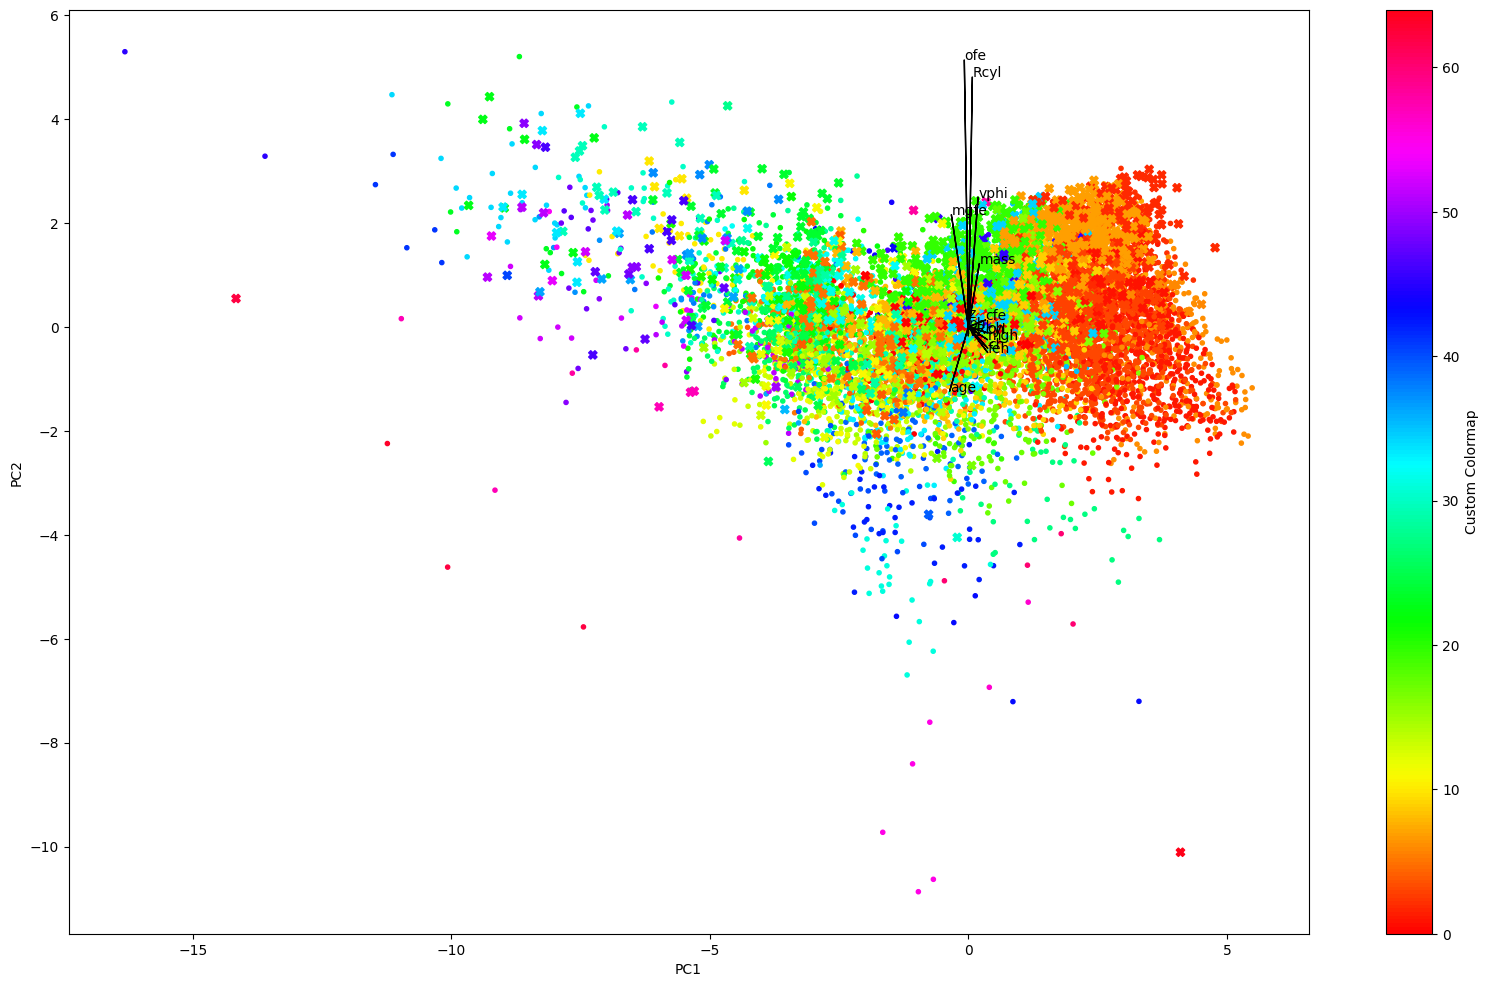

In [13]:
scale_arrow = s_ = 8
i, j = 0, 1 # which components

#color of clusters 
#make it so it maches  ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'grey']
colors = cluster_colors
node_lin_space = np.linspace(0, 1, len(colors))
nodes = node_lin_space.tolist()  # Position of colors in the colormap (0=low, 1=high)

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

fig, ax = plt.subplots(1, 1, figsize=(20, 12)) 

mask1 = isMigrator == 1
mask0 = isMigrator == 0


scatter0 = ax.scatter(scores[:,0][mask0], scores[:,1][mask0], marker = '.', c = cluster_label[mask0], cmap=custom_cmap)
scatter1 = ax.scatter(scores[:,0][mask1], scores[:,1][mask1], marker = 'X', c = cluster_label[mask1], cmap=custom_cmap) 


ax.set_xlabel('PC%d' % (i+1))  
ax.set_ylabel('PC%d' % (j+1))

#This part is for plotting the components ie murder, assult, urbanpop and rape. 
for k in range(pcaMigrator.components_.shape[1]):
    ax.arrow(0, 0, pcaMigrator.components_[i,k], s_ * pcaMigrator.components_[j,k]) 
    ax.text(pcaMigrator.components_[i,k], s_ * pcaMigrator.components_[j,k], 
            data.columns[k])


cbar0 = plt.colorbar(scatter0, ax=ax)
cbar0.set_label("Custom Colormap")